In [1]:
from torch import nn
import torch
from torchsummary import summary
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1 or classname.find('Linear')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, padding=1)
        self.in1 = nn.InstanceNorm2d(128, affine=True)
        #LeakyReLU
        self.conv3 = nn.Conv2d(128, 256, 4, 2, padding=1)
        self.in2 = nn.InstanceNorm2d(256, affine=True)
        #LeakyReLU
        self.conv4 = nn.Conv2d(256, 256, 4, 2, padding=1)
        self.in3 = nn.InstanceNorm2d(256, affine=True)
        #LeakyReLU
        self.conv5 = nn.Conv2d(256, 512, 4, padding='same')
        self.in4 = nn.InstanceNorm2d(512, affine=True)
        #LeakyReLU
        self.conv6 = nn.Conv2d(512, 1, 4, padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.in1(self.conv2(x)))
        x = self.lrelu(self.in2(self.conv3(x)))
        x = self.lrelu(self.in3(self.conv4(x)))
        x = self.lrelu(self.in4(self.conv5(x)))
        x = self.sigmoid(self.conv6(x))
        return x

In [6]:
# netD_AB = Discriminator(3).to(device)
netD_AB = Discriminator().to(device)
# netD_AB.apply(weights_init)

summary(netD_AB, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 256, 16, 16]       1,048,832
   InstanceNorm2d-10          [-1, 256, 16, 16]             512
        LeakyReLU-11          [-1, 256, 16, 16]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,664
   InstanceNorm2d-13          [-1, 512, 16, 16]           1,024
        LeakyReLU-14          [-1, 512,

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1041.)
  return F.conv2d(input, weight, bias, self.stride,


In [7]:
class ResNetBlock(nn.Module):
    def __init__(self, n_inp, n_out):
        super().__init__()
        self.conv1 = nn.LazyConv2d(n_out, 3, padding='same')
        self.in1 = nn.InstanceNorm2d(n_out)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(n_out, n_out, 3, padding='same')
        self.in2 = nn.InstanceNorm2d(n_out)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(self.in1(out))
        out = self.in2(self.conv2(out))
        return torch.concatenate((out, x), dim=1)

In [9]:
class Generator(nn.Module):
    def __init__(self, n_resnet=9) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, padding='same')
        self.in1 = nn.InstanceNorm2d(64, affine=True)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, 3, 2, padding=1)
        self.in2 = nn.InstanceNorm2d(128, affine=True)
        #ReLU
        self.conv3 = nn.Conv2d(128, 256, 3, 2, padding=1)
        self.in3 = nn.InstanceNorm2d(256, affine=True)
        #ReLU
        self.resL = nn.ModuleList([ResNetBlock(256, 256) for _ in range(n_resnet)])
        self.convt1 = nn.ConvTranspose2d(2560, 128, 3, 2, padding=1, output_padding=1)
        self.in4 = nn.InstanceNorm2d(128, affine=True)
        #ReLU
        self.convt2 = nn.ConvTranspose2d(128, 64, 3, 2, padding=1, output_padding=1)
        self.in5 = nn.InstanceNorm2d(64, affine=True)
        #ReLU
        self.conv4 = nn.Conv2d(64, 3, 7, padding='same')
        self.in6 = nn.InstanceNorm2d(3, affine=True)
        self.tanh = nn.Tanh()
        
    
    def forward(self, x):
        x = self.relu(self.in1(self.conv1(x)))
        x = self.relu(self.in2(self.conv2(x)))
        x = self.relu(self.in3(self.conv3(x)))
        for block in self.resL:
            x = block(x)
        x = self.relu(self.in4(self.convt1(x)))
        x = self.relu(self.in5(self.convt2(x)))
        x = self.tanh(self.in6(self.conv4(x)))
        return x

In [10]:
# netG_AB = Generator(3,64,9).to(device)
netG_AB = Generator().to(device)

summary(netG_AB, (3, 256, 256))

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-5        [-1, 128, 128, 128]             256
              ReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-8          [-1, 256, 64, 64]             512
              ReLU-9          [-1, 256, 64, 64]               0
           Conv2d-10          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-11          [-1, 256, 64, 64]               0
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-14          [-1, 256,

In [11]:
class ToRGB(object):
    def __call__(self, img):
        if img.mode == 'L':
            img = img.convert('RGB')
        return img

transform = transforms.Compose([
    ToRGB(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


In [12]:
def load_images(path):
    data_list = list()
    for filename in os.listdir(path):
        img = Image.open(os.path.join(path, filename))
        img = transform(img)
        data_list.append(img)
    return data_list

In [13]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, pathA1, pathA2, pathB1, pathB2):
        self.dataA1 = load_images(pathA1)
        self.dataA2 = load_images(pathA2)
        self.dataA = self.dataA1 + self.dataA2
        self.dataB1 = load_images(pathB1)
        self.dataB2 = load_images(pathB2)
        self.dataB = (self.dataB1 + self.dataB2)[:len(self.dataA)]
        assert len(self.dataA) == len(self.dataB), f"Los tamaños no coinciden {len(self.dataA), len(self.dataB)}"

    def __len__(self):
        return len(self.dataA)

    def __getitem__(self, idx):
        return (self.dataA[idx], self.dataB[idx])

dataset = CustomDataset("data/testA/", "data/trainA/", "data/testB/", "data/trainB/")

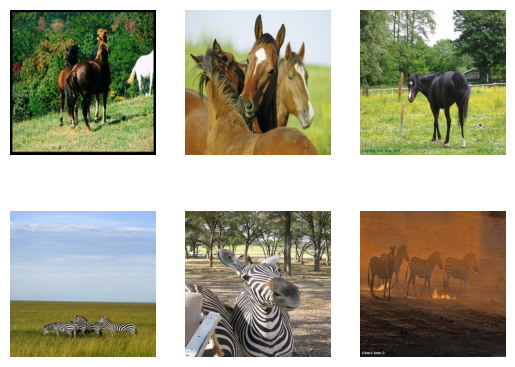

In [14]:
n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis("off")
    plt.imshow((dataset[i][0].permute(1, 2, 0)+1)/2)
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis("off")
    plt.imshow((dataset[i][1].permute(1, 2, 0)+1)/2)

In [15]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [16]:
netD_AB = Discriminator().to(device)
# netD_AB.apply(weights_init)
netG_AB = Generator().to(device)

netD_BA = Discriminator().to(device)
# netD_BA.apply(weights_init)
netG_BA = Generator().to(device)

In [17]:
import itertools

EPOCH_NUM = 100
LR=1e-5

criterion_MSE = nn.MSELoss()
criterion_L1 = nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(netG_AB.parameters(), netG_BA.parameters()), lr=LR, betas=(0.5, 0.999)
)

optimizer_D = torch.optim.Adam(list(netD_BA.parameters()) + list(netD_AB.parameters()), lr=LR, betas=(0.5, 0.999))

In [18]:
def save_image(img_list, epoch):
    plt.figure(figsize=(16, 16));
    plt.axis("off")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    if not os.path.exists('generated'):
        os.makedirs('generated')
    plt.savefig("generated/img%d.png" % epoch, bbox_inches='tight', pad_inches=0)

In [19]:
if True:
    netG_AB.load_state_dict(torch.load('data/modeloG_AB.pth'))
    netG_BA.load_state_dict(torch.load('data/modeloG_BA.pth'))
    netD_AB.load_state_dict(torch.load('data/modeloD_AB.pth'))
    netD_BA.load_state_dict(torch.load('data/modeloD_BA.pth'))

In [20]:
import torchvision.utils as vutils
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

img_list = []
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
logdir = f"trainings/{timestamp}/"
writer = SummaryWriter(logdir)
global_step = 0

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

for ep in range(EPOCH_NUM):
    netG_AB.train()
    netG_BA.train()
    
    torch.cuda.empty_cache()
    
    batch_iterator = tqdm(dataloader, desc=f"Processing Epoch {ep+1:02d}")
    
    for i, (horse, zebra) in enumerate(batch_iterator):
        zebra = zebra.to(device)
        horse = horse.to(device)

        with torch.cuda.amp.autocast():
            fake_horse = netG_BA(zebra)
            D_H_real = netD_BA(horse)
            D_H_fake = netD_BA(fake_horse.detach())
            D_H_real_loss = criterion_MSE(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = criterion_MSE(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss
            fake_zebra = netG_AB(horse)
            D_Z_real = netD_AB(zebra)
            D_Z_fake = netD_AB(fake_zebra.detach())
            D_Z_real_loss = criterion_MSE(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = criterion_MSE(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss
            D_loss = (D_H_loss + D_Z_loss) / 2
            
        optimizer_D.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(optimizer_D)
        d_scaler.update()

        with torch.cuda.amp.autocast():
            D_H_fake = netD_BA(fake_horse)
            D_Z_fake = netD_AB(fake_zebra)
            loss_G_H = criterion_MSE(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = criterion_MSE(D_Z_fake, torch.ones_like(D_Z_fake))
            # cycle losses
            cycle_zebra = netG_AB(fake_horse)
            cycle_horse = netG_BA(fake_zebra)
            cycle_zebra_loss = criterion_L1(zebra, cycle_zebra)
            cycle_horse_loss = criterion_L1(horse, cycle_horse)
            # identity losses
            # identity_zebra = gen_Z(zebra)
            # identity_horse = gen_H(horse)
            # identity_zebra_loss = l1(zebra, identity_zebra)
            # identity_horse_loss = l1(horse, identity_horse)
            # total loss
            G_loss = (
            loss_G_Z
                + loss_G_H
                + cycle_zebra_loss * 10
                + cycle_horse_loss * 10
                # + identity_horse_loss * LAMBDA_IDENTITY
                # + identity_zebra_loss * LAMBDA_IDENTITY
            )
        
        optimizer_G.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(optimizer_G)
        g_scaler.update()
        writer.add_scalars('losses', {'DLoss': D_loss.item(), 'GLoss': G_loss.item()}, global_step)
        writer.flush()
        global_step += 1
        
        
    if ep % 2 == 0:
        with torch.no_grad():
            fake = netG_AB(torch.stack([dataset[i][0] for i in range(49)], 0).to(device)).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True, nrow=7))
        save_image(img_list, ep+1)

In [ ]:
torch.save(netG_AB.state_dict(), 'data/modeloG_AB.pth')
torch.save(netG_BA.state_dict(), 'data/modeloG_BA.pth')
torch.save(netD_AB.state_dict(), 'data/modeloD_AB.pth')
torch.save(netD_BA.state_dict(), 'data/modeloD_BA.pth')

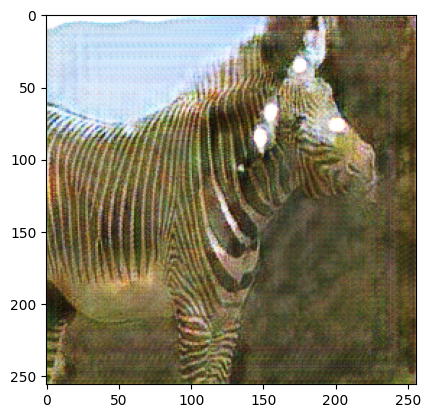

In [ ]:
for i, (horse, zebra) in enumerate(batch_iterator):
    plt.imshow((netG_BA(zebra.to(device)).squeeze(0).permute(1,2,0).cpu().detach().numpy()+1)/2) if i < 1 else None

In [ ]:
with torch.no_grad():
    fake = netG_BA(torch.stack([dataset[i][1] for i in range(49)], 0).to(device)).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True, nrow=7))
save_image(img_list, ep+1)